![dsl logo](https://github.com/BrockDSL/ARCH_Data_Explore/blob/main/dsl_logo.png?raw=true)

# Plots displaying the average size of municipal page content in the years of 2020 and 2021.

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact

In [39]:
def download_file(url, filename=None, loud=True):
  
  if not filename:
    filename = url.split('/')[-1]
  
  r = requests.get(url, stream=True)
  if loud:
    total_bytes_dl = 0
    content_len = int(r.headers['Content-Length'])

  with open(filename, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=4096):
          fd.write(chunk)
          if loud:
            total_bytes_dl += 4096
            percent = int((total_bytes_dl / content_len) * 100.0)
            print(f'\rDownload progress of {filename} {total_bytes_dl}/{content_len}: {percent}%',end='')
  r.close()

def get_muni_data():
  download_file("https://brockau.s3.us-east-2.amazonaws.com/url_cv19.csv.gz")
  archive_data = pd.read_csv("url_cv19.csv.gz")
  archive_data.crawl_date = pd.to_datetime(archive_data.crawl_date)
  archive_data.content = archive_data.content.astype("string")
  return archive_data

#Not really needed since url_cv19 dataset has been filtered for this, but do it for safety anyways
r = requests.get('https://raw.githubusercontent.com/BrockDSL/ARCH_Data_Explore/main/urls_of_interest.txt')
urls_of_interest = r.text.split()

domains = [
"westlincoln.ca",
"thorold.ca",
"forterie.ca",
"welland.ca",
"niagararegion.ca",
"notl.com",
"wainfleet.ca",
"portcolborne.ca",
"grimsby.ca",
"lincoln.ca",
"pelham.ca",
"niagarafalls.ca",
"stcatharines.ca"]

#Retrieve data 
data = get_muni_data()
data['length'] = data.loc[data.content.notna()].apply(lambda row: len(row.content), axis=1)

data = data[data.url.isin(urls_of_interest)].sort_values(by=['domain', 'url', 'crawl_date', 'content'])
for url in urls_of_interest:
  data.loc[data.url == url, ['content']] = data.loc[data.url == url].content.fillna(method='ffill')
data = data.drop_duplicates(subset=['crawl_date','url','content']).set_index('domain')                                        

Download progress of url_cv19.csv.gz 4116480/4116015: 100%

In [40]:
def monthly_means(data):
  content_means= []

  for d in domains:
    means = data.loc[d].groupby(pd.Grouper(freq='1M', key='crawl_date')).mean()
    means['domain'] = d
    content_means.append(means)
  
  return pd.concat(content_means)
  
data_2020 = monthly_means(data[data.crawl_date < '2021-01-01'])
data_2021 = monthly_means(data[data.crawl_date >= '2021-01-01'])


Examine a given domain's average monthly page size in 2020 vs 2021

In [42]:
def plot_domain(domain):
  fig, axs = plt.subplots(2, 2,figsize=(24,16))
  plt.subplots_adjust(hspace=.3)

  def plot_year(axs, data, year):
    ax, ax2 = axs
    barchart_data = data[data.domain == domain]
    x_pos = range(len(barchart_data))
    ax.bar(x_pos,barchart_data.length)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(barchart_data.index.strftime('%Y-%m-%d'), rotation=90)
    ax.set_ylabel('Mean Page length')
    ax.set_xlabel('Months')
    ax.set_title(f'Mean municipality page length for {year}')

    ax2.plot(x_pos, barchart_data.length)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(barchart_data.index.strftime('%Y-%m-%d'), rotation=90)
    ax2.set_ylabel('Mean Page length')
    ax2.set_xlabel('Months')
    ax2.set_title(f'Mean municipality page length for {year}')

  plot_year(axs[0], data_2020, 2020)
  plot_year(axs[1], data_2021, 2021)
interact(plot_domain, domain=domains);

interactive(children=(Dropdown(description='domain', options=('westlincoln.ca', 'thorold.ca', 'forterie.ca', '…

Compare the size of pages for each municipality (monthly average) in 2020 vs 2021

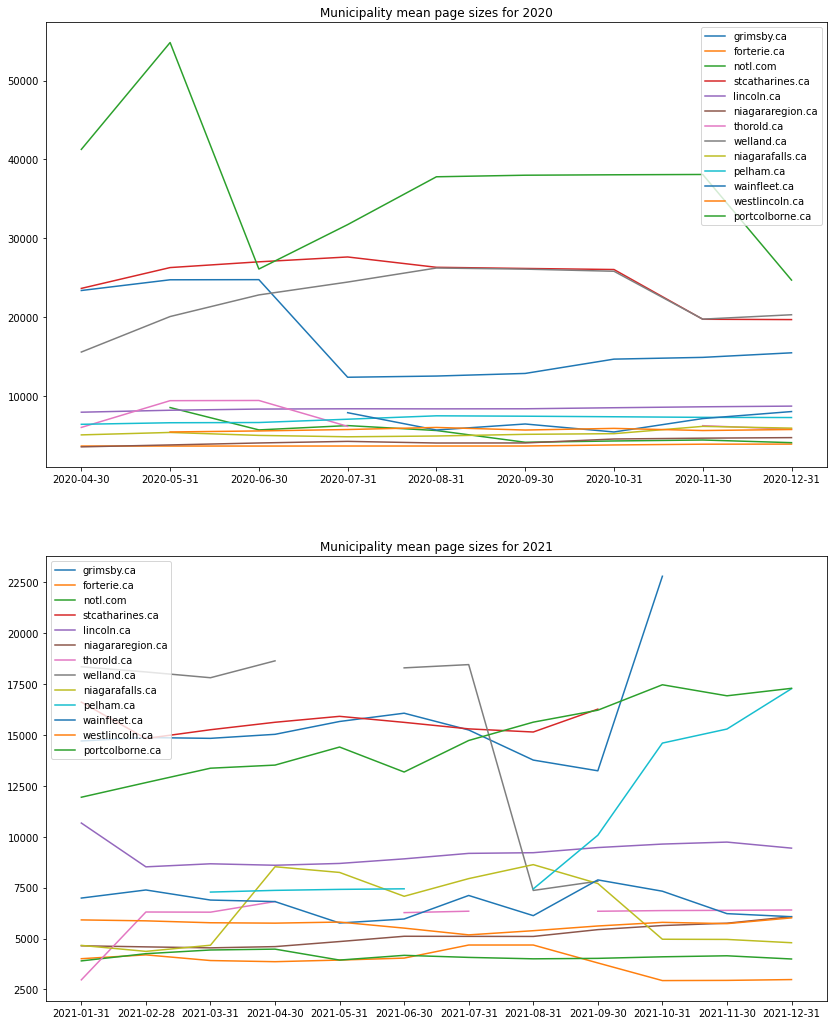

In [43]:
def plot_combined(ax, data, year):
  for d in set(data.domain):
    xdata = data[data.domain == d].index.strftime('%Y-%m-%d')
    ydata = data[data.domain == d].length
    ax.plot(xdata,ydata, label=d)
    ax.legend()
    ax.set_title(f"Municipality mean page sizes for {year}")

fig, ax = plt.subplots(2, 1, figsize=(14,18))
plot_combined(ax[0], data_2020, '2020')  
plot_combined(ax[1], data_2021, '2021')

Compare the average size of municipal pages month over month, for each year.

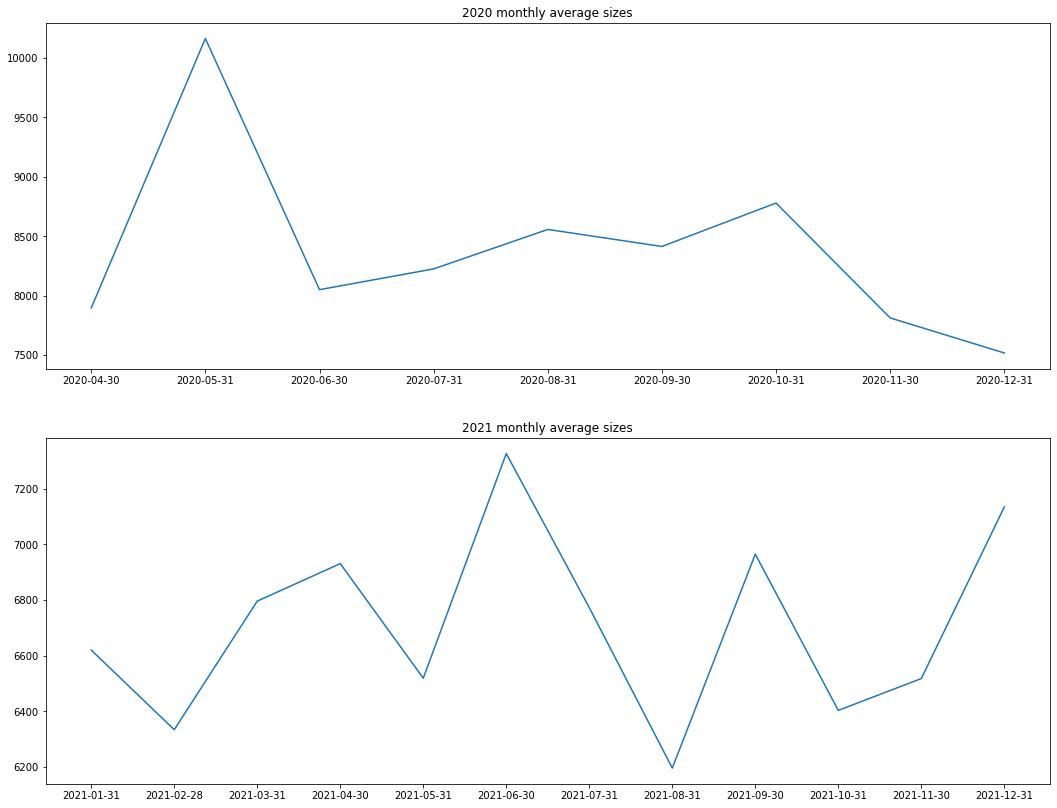

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(18,14))

def plot_year_means(ax, data, year):
  ax.plot(data.index.strftime('%Y-%m-%d'), data.length)
  ax.set_title(f"{year} monthly average sizes")

means_2020 = data[data.crawl_date < '2021-01-01'].groupby(pd.Grouper(freq='1M', key='crawl_date')).mean()
means_2021 = data[data.crawl_date >= '2021-01-01'].groupby(pd.Grouper(freq='1M', key='crawl_date')).mean()
plot_year_means(ax[0],means_2020,'2020')
plot_year_means(ax[1],means_2021,'2021')

